In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import math
import time
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import numpy as np
from  scipy import stats
import scipy
np.random.seed(1)
torch.manual_seed(1)
random.seed(1)

Сетка по статье https://drive.google.com/file/d/1ia3W9vgdZLurEx4R7ndVL05clQLEarKF/view?usp=sharing .

In [ ]:
import os
os.chdir("/content/drive/MyDrive/MADE/Project/deap")

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
class Args:
  def __init__(self): #(data_path, epoch, batch_siz, image_size, learning_rate, weight_deca, learning_rate, learning_rate_gamma, weight_bce, load, output_dir)
    self.data_path = "/content/drive/MyDrive/MADE/semester2/CV/contest02/data/"
    self.epochs = 2
    self.batch_size = 1000
    self.lr= 3e-4
    self.weight_decay= 1e-6
    self.learning_rate=None
    self.learning_rate_gamma=None
    self.weight_bce=1
    self.load=None
    self.output_dir="/content/drive/MyDrive/MADE/Project/RACNN_models/"
    self.data_dir ="./data_preprocessed_python/"# "/content/drive/MyDrive/MADE/Project/train/physionet.org/"
args = Args()   

In [ ]:
def get_padding(in_size, kernel_size, stride):
    if (in_size % stride == 0):
        padding = max(kernel_size - stride, 0)
    else:
        padding = max(kernel_size - (in_size % stride), 0)
    return (padding)    

In [ ]:
def get_temporal_feature_extractor(input_size, batch_norm):
  pad = get_padding(input_size, 5,  2)
  conv1 = nn.Conv3d(1, 32, kernel_size = (1, 1, 5), stride=(1, 1, 2), padding=(0, 0, 2))
  bn1 = nn.BatchNorm3d(32)
  relu1 = nn.ReLU()
  pad = get_padding(input_size, 3,  2)
  conv2 = nn.Conv3d(32, 32, kernel_size = (1, 1, 3), stride=(1, 1, 2), padding=(0, 0, pad))
  bn2 = nn.BatchNorm3d(32)
  relu2 = nn.ReLU()
  conv3 = nn.Conv3d(32, 32, kernel_size = (1, 1, 3), stride=(1, 1, 2), padding=(0, 0, pad))
  bn3 = nn.BatchNorm3d(32)
  relu3 = nn.ReLU()
  conv4 = nn.Conv3d(32, 32, kernel_size = (1, 1, 16), stride=(1, 1, 16), padding=0)
  bn4 = nn.BatchNorm3d(32)
  relu4 = nn.ReLU()
  #print("11")
  if batch_norm == True:
      return (torch.nn.Sequential(conv1, bn1, relu1, conv2, bn2, relu2, conv3, bn3, relu3, conv4, bn4 ,relu4))
  else:
      return (torch.nn.Sequential(conv1, relu1, conv2, relu2, conv3, relu3, conv4, relu4))
  

In [ ]:
def get_regional_feature_extractor(batch_norm):
  conv1 = nn.Conv2d(32, 32, kernel_size = (3, 3), stride=1 , padding='same')
  bn1 =   nn.BatchNorm2d(32)
  relu1 = nn.ReLU()
  conv2 = nn.Conv2d(32, 32, kernel_size = (3, 3), stride=1 , padding='same')
  bn2 =   nn.BatchNorm2d(32)
  relu2 = nn.ReLU()
  if batch_norm == True:
      return(torch.nn.Sequential(conv1, bn1, relu1, conv2, bn2, relu2))
  else:    
      return(torch.nn.Sequential(conv1, relu1, conv2, relu2))

In [ ]:
class Asymmetric_feature_extractor(torch.nn.Module): 
   def __init__(self, batch_norm = True):
     super().__init__()
     self.conv = nn.Conv2d(32, 64, kernel_size = 1, stride=1 , padding='same')
     self.relu = nn.ReLU()
     self.bn =   nn.BatchNorm2d(64)
     self.batch_norm = batch_norm
   def forward(self, input):
     #input(bs, nf, h, w)
     #print(input.shape)
     half_mat = torch.split(input, (4, 1, 4), dim = 3)
     temp = half_mat[2][:, :, :, [3, 2, 1, 0]]
     input_new = half_mat[0] - temp
     #print(input_new)
     #print(half_mat[0].shape)
     #print(half_mat[2].shape)
     #input_new =  half_mat[0] -  half_mat[2]
     #print(input.shape)
     output = self.conv(input_new)
     if self.batch_norm:
          output = self.bn(output)
     output = self.relu(output)
     #print(output.shape)
     return output

def get_asymmetric_feature_extractor(batch_norm  = True):
    return (Asymmetric_feature_extractor())


In [ ]:
LEN_RECORD_IN_SECONDS = 60
NVIDEOS = 40
HCANALS = 9
WCANALS = 9
NTIMES_IN_SAMPLE = 128
NTIMES_IN_SEC = 128
NCANALS = 32
NFEATURES = 32
NSUBJECTS = 32
electrode_matrix = {}
electrode_matrix['FP1'] = [0, 3]
electrode_matrix['FP2'] = [0, 5]
electrode_matrix['AF3'] = [1, 3]
electrode_matrix['AF4'] = [1, 5]
electrode_matrix['F7']  = [2, 0]
electrode_matrix['F3']  = [2, 2]
electrode_matrix['FZ']  = [2, 4]
electrode_matrix['F4']  = [2, 6]
electrode_matrix['F8']  = [2, 8]
electrode_matrix['FC5']  = [3, 1]
electrode_matrix['FC1']  = [3, 3]
electrode_matrix['FC2']  = [3, 5]
electrode_matrix['FC6']  = [3, 7]
electrode_matrix['T7']  = [4, 0]
electrode_matrix['C3']  = [4, 2]
electrode_matrix['CZ']  = [4, 4]
electrode_matrix['C4']  = [4, 6]
electrode_matrix['T8']  = [4, 8]
electrode_matrix['CP5']  = [5, 1]
electrode_matrix['CP1']  = [5, 3]
electrode_matrix['CP2']  = [5, 5]
electrode_matrix['CP6']  = [5, 7]
electrode_matrix['P7']  = [6, 0]
electrode_matrix['P3']  = [6, 2]
electrode_matrix['PZ']  = [6, 4]
electrode_matrix['P4']  = [6, 6]
electrode_matrix['P8']  = [6, 8]
electrode_matrix['PO3'] = [7, 3]
electrode_matrix['PO4'] = [7, 5]
electrode_matrix['O1'] = [8, 3]
electrode_matrix['OZ'] = [8, 4]
electrode_matrix['O2'] = [8, 5]

list_electrodes = ['FP1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3',	'T7',	'CP5',	'CP1',	'P3',	'P7',	'PO3',	'O1',	'OZ',	'PZ',	'FP2',	'AF4', 'FZ', 'F4', 'F8', 'FC6',	'FC2',	'CZ', 'C4', 'T8', 'CP6',	'CP2',	'P4', 	'P8',	'PO4',	'O2']
data_dir = './data_preprocessed_python'
TRAIN_SIZE = 0.9
THRESHOLD = 4.5

In [ ]:
from collections import Counter
import scipy
from scipy.fft import fft, ifft


class RandomAugmentation(object):
    def __init__(self, augmenters, probability):
        self._augmenters = augmenters
        self.probability = probability

    def __call__(self, sample):
        augmenter = random.choice(self._augmenters)
        #print(augmenter)
        if (augmenter):
            if (np.random.random() < self.probability):
               return augmenter(sample)
        return(sample)  


class add_noise(object):
    def __init__(self, ):
        super(add_noise, self).__init__()

    def __call__(self, sample: dict):
        white_noise = np.random.normal(loc=0.0, scale=1.0, size=sample['data'].shape)
        sample['data'] = sample['data'] + white_noise
        return sample


class reset_part_in_time(object):
    def __init__(self, percentage):
        super(reset_part_in_time, self).__init__()
        self.percentage = percentage

    def __call__(self, sample: dict):
        len_data = len(sample['data'][0])
        interval_to_reset = int(len_data * self.percentage)
        for ncanal in range(NVIDEOS):
            begin = random.randint(0, len_data - interval_to_reset)
            sample['data'][ncanal, begin : begin + interval_to_reset] = 0

        return sample


class reset_part_in_freq(object):
    def __init__(self, percentage):
        super(reset_part_in_freq, self).__init__()
        self.percentage = percentage

    def __call__(self, sample: dict):
        len_data = len(sample['data'][0])
        interval_to_reset = int(len_data * self.percentage)
        power_freq_data = fft(sample['data'])
        for ncanal in range(NVIDEOS):
            begin = random.randint(0, len_data - interval_to_reset)
            power_freq_data[ncanal, begin : begin + interval_to_reset] = 0
        sample['data'] = ifft(power_freq_data)
        return sample

       

class to_head_matrix(object):
    def __init__(self):
        super(to_head_matrix, self).__init__()
        

    def __call__(self, sample: dict):
        input = sample['data'].copy()
        sample['data'] = np.zeros((HCANALS, WCANALS, NTIMES_IN_SAMPLE))
        #sample_from_one_canals = []
        #for i_canal in range(NCANALS):
        #     sample_from_one_canal = input[i_canal]
        #     sample_from_one_canals.append(sample_from_one_canal)
        #print(sample_from_one_canal.shape)
        #sample_from_one_canals = np.asarray(sample_from_one_canals).copy()
      # здесь делаем нормализацию фактически по поверхности головы (по одному времени t для всех каналов)
        #sample_from_one_canals = scipy.stats.zscore(input, axis = 0)
        sample_from_one_canals = input
        for i_canal in range(NCANALS):
             sample['data'][electrode_matrix[list_electrodes[i_canal]][0],  electrode_matrix[list_electrodes[i_canal]][1]] = sample_from_one_canals[i_canal]
        return sample     

class ToTensor(object):

    def __init__(self, ):
        super(ToTensor, self).__init__()

    def __call__(self, sample: dict):
        return {"labels": torch.tensor(sample["labels"], dtype=torch.long),
                "data": torch.tensor(sample["data"], dtype=torch.float32),
                } 





class EmotionDataset(Dataset):
    def __init__ (self, data, labels_bin, transforms, indexes, interval = 1):  #indexes - индексы видео которые вошли в датасет, data - данные labels - метки бинарные
       self.data_samples = []
       self.labels = []
       self.transforms = transforms
       self.cnt = [Counter(), Counter(), Counter(),Counter()]
       for sub in range(len(data)): #sub   - человек
          for nvideo in range(NVIDEOS):
             
             for nsec in range(LEN_RECORD_IN_SECONDS):
                    self.data_samples.append(data[sub][nvideo, :,  (3 + nsec) * NTIMES_IN_SEC : (3 + nsec + interval) * NTIMES_IN_SEC])
                    self.labels.append(labels_bin[sub][nvideo, :])
                    

       self.data_samples = np.array(self.data_samples)[np.array(indexes)]
       self.labels = np.array(self.labels)[np.array(indexes)]
       for i in range(4):
          self.cnt[i].update(self.labels[:, i])
       

    def __len__(self):
       result =  len(self.data_samples)
       return result

    def __getitem__(self, item):
       sample = {}   
       sample = {"labels": self.labels[item],
                 "data": self.data_samples[item]
       }

       if self.transforms is not None:
           for t in self.transforms:
                sample = t(sample)
       #print(sample)         
       return sample
                 

In [ ]:
class EmotionNet(torch.nn.Module): 
   def __init__(self, hcanals, wcanals, nfeatures, ntimes_in_sample, batch_norm = True, reg_extractor = True, ass_extractor = True):
      super().__init__()
      #print("1")
      self.reg_extractor = reg_extractor
      self.ass_extractor = ass_extractor
      self.tfe = get_temporal_feature_extractor(ntimes_in_sample, batch_norm ) #(bs, 1, h = 9, w = 9, s = 128) -> (bs, h = 9, w = 9, s = 1)
      #print("2")
      if (reg_extractor):
          self.rfe = get_regional_feature_extractor(batch_norm) #(h = 9, w = 9, s = 32) -> (h = 9, w = 9, s = 32)
      #print("3")
      if ass_extractor:
          self.afe = get_asymmetric_feature_extractor(batch_norm)
      #print("4")
      self.flat1 = nn.Flatten(1, 3)
      self.flat2 = nn.Flatten(1, 3)
      self.input_linear_size = 0
      if (not reg_extractor and not ass_extractor) :
          self.input_linear_size =  hcanals * wcanals * nfeatures
      else:
          if (ass_extractor) :   
              self.input_linear_size += int(hcanals * (wcanals//2)* nfeatures * 2)
          if (reg_extractor) :   
              self.input_linear_size += hcanals * (wcanals)* nfeatures    
      #print(self.input_linear_size)
      #print("5")
      self.fc1 = nn.Linear(self.input_linear_size, 20)
      self.relu1 = nn.ReLU()
      self.drop = nn.Dropout(0.3)
      self.fc2 = nn.Linear(20, 2)
   def forward(self, input):
      input = input.unsqueeze(1)
      #print(f"input_shape = {input.shape}")
      
      #input (bs, in_canals = 1,  h=9, w=9, s=128)
      output_tfe = self.tfe(input)
      #print(f"output_tfe.shape = {output_tfe.shape}")
      #output_tfe (bs, in_canals = 32,  h=9, w=9, s=1)
      output_tfe = output_tfe.squeeze(4)
      #print(f"output_tfe.shape = {output_tfe.shape}")
      
      #output_rfe (bs, canals = 32,  h=9, w=9)

      if (self.reg_extractor) :   
            output_rfe = self.rfe(output_tfe)

      #print(f"output_rfe.shape = {output_rfe.shape}")
      if (self.ass_extractor) :   
            output_afe = self.afe(output_tfe)

      #output_rfe = output_rfe.permute(0, 2, 3, 1) 
      #output_rfe (bs, h=9, w=9, 32)
      #output_afe = output_afe.permute(0, 2, 3, 1) 
      #output_afe (bs, h=9, w=4, 64)
      #print(f"output_afe.shape = {output_afe.shape}")
      #output_rfe (bs, canals = 64,  h=4, w=9)
      if (self.reg_extractor) :   
          output_rfe_flatten = self.flat1(output_rfe)
      #print(f"output_rfe_flatten.shape = {output_rfe_flatten.shape}")
      if (self.ass_extractor) :   
          output_afe_flatten = self.flat2(output_afe)
      if (not self.reg_extractor and not self.ass_extractor) :          
          output_tfe_flatten = self.flat1(output_tfe)
          output1 = self.drop(self.fc1(output_tfe_flatten))
      if (self.reg_extractor) and (self.ass_extractor):   
          output1 = self.drop(self.fc1(torch.cat((output_rfe_flatten, output_afe_flatten), dim = 1)))
      else:    
          if (self.reg_extractor) :   
               output1 = self.drop(self.fc1(output_rfe_flatten))        
          if (self.ass_extractor) :   
               output1 = self.drop(self.fc1(output_afe_flatten))             

      #print(f"output_afe_flatten.shape = {output_afe_flatten.shape}")
      #output1 = self.drop(self.fc1(torch.cat((output_rfe_flatten, output_afe_flatten), dim = 1)))
      #print(f"output1.shape = {output1.shape}")
      output1_relu = self.relu1(output1)
      #print(f"output1_relu.shape = {output1_relu.shape}")
      output2 = self.fc2(output1_relu)
      #print(f"output2.shape = {output2.shape}")
      return output2


In [ ]:
def get_model(batch_norm = True, reg_extractor = True, ass_extractor = True):
  model = EmotionNet(HCANALS, WCANALS, NFEATURES, NTIMES_IN_SAMPLE, batch_norm, reg_extractor, ass_extractor).to(device)
  return model


Считываем данные

In [ ]:
import glob
import pickle
from sklearn.preprocessing import MinMaxScaler

data = []
labels = []
data_dir = './data_preprocessed_python'
files = glob.glob(os.path.join(data_dir, "*.dat"))
data_raw = []
for file_data in files:
    raw_data = pickle.load(open(file_data, 'rb'), encoding='latin1')
    data.append(raw_data['data'])
    labels.append(raw_data['labels'])
    #break

In [ ]:
# def remove_baseline():
#   for sub in range(NSUBJECTS):
#     for nvideo in range(NVIDEOS):
#         for ncanal in range(NCANALS):
#             baseline_mean = (data[sub][nvideo, ncanal, 0: 128] + data[sub][nvideo, ncanal, 128: 128  *2] + data[sub][nvideo, ncanal, 128 * 2: 128 * 3])/3
#             #print(baseline_mean.shape)
#             for nsec in range(60):
#                      data[sub][nvideo, ncanal, nsec * 128 : nsec * 128 + 128] = data[sub][nvideo, ncanal, nsec * 128 : nsec * 128 + 128] - baseline_mean

# remove_baseline()

In [ ]:
# def normalize_data():
#   for sub in range(NSUBJECTS):
#     for nvideo in range(NVIDEOS):
#         for ncanal in range(NCANALS):
#              #std = np.std(data[sub][nvideo, ncanal, :])
#              #data[sub][nvideo, ncanal, :] = np.clip(data[sub][nvideo, ncanal, :], -3 * std, 3 * std)
#              scaler = MinMaxScaler(feature_range=(-1, 1))
#              data[sub][nvideo, ncanal, :] = scaler.fit_transform(data[sub][nvideo, ncanal, :].reshape(-1, 1)).reshape(1, -1)
#              #data[sub][nvideo, ncanal, :]  = data[sub][nvideo, ncanal, :]  - data[sub][nvideo, ncanal, :].mean()

# normalize_data()

Отлаживаюсь на эмоции с индексом 1 (valence)

In [ ]:
type_emotion = 1

Бинаризуем метки и разбиваем видео для каждого человека в соответствии с метками этого человека - оно не всегда будет сбалансированным, как оказалось, но хотя бы метки буду представлены наиболее равномерно. Выведем количестов меток 1 для каждого человека в разбиении

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
k  = 5
labels_bin = []
for sub in range(32):
  temp = labels[sub] >= 4.5
  #print(labels[i])
  #print(temp)
  labels_bin.append(temp)
  print(sum(labels_bin[sub][:, type_emotion]), end=' ')




25 25 21 25 31 29 23 18 35 35 27 22 20 26 27 28 34 32 29 16 35 31 20 28 20 27 25 21 29 9 18 27 

распределение положительных меток в датасете по каждой эмоции

In [ ]:
# print(train_dataset.cnt)
# print(val_dataset.cnt)


In [ ]:
def train(model, loader, criterion, optimizer, device, val_dataloader, val_f1_min,  description, type_emotion, batch = None, writer = None):
    model.train()
    train_loss = []
    inputs = []
    torch.autograd.set_detect_anomaly(True)
   
    #lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)#, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
    for i , batch in enumerate(loader):#, total=len(loader), desc="training...", position=0 , leave = True)):
            model.train()
            optimizer.zero_grad()
            src  = batch['data'].to(device)
            trg = batch['labels'][:, type_emotion]
            levels_pred = model(src)  # B x (2 * NUM_PTS)
            levels_pred = levels_pred.cpu()
            loss = criterion(levels_pred, trg) 
            train_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            if writer:
                writer.add_scalar(f'{description}/training loss per batch',
                                  loss.item(),
                                  i)

            # if (i % 100 == 0):
            #     acc, f1 = (calculate_predictions(model, val_dataloader))
            #     if (f1 > val_f1_min):
            #           val_f1_min      = f1
            #           torch.save({'model_state_dict': model.state_dict(),    'optimizer_state_dict': optimizer.state_dict(),}, os.path.join(args.output_dir, f"val.tgz"))
            #break
    return np.mean(train_loss), val_f1_min

def evaluate(model, loader, criterion, device, writer, description, type_emotion):
    
    model.eval()
    epoch_loss = 0
    history = []
  
    with torch.no_grad():
    
        for s, batch in enumerate(loader):#, total=len(loader), desc="validating...", position=0 , leave = True)):
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, type_emotion]



            levels_pred = model(src)  # B x (2 * NUM_PTS)
            #print(levels_pred.shape)
            levels_pred = levels_pred.cpu()
            loss = criterion(levels_pred, trg) 
            epoch_loss += loss.item() 


            if writer:
                writer.add_scalar(f'{description}/val loss per batch',
                                  loss.item(),
                                  s)
        
    return epoch_loss / s
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

def calculate_predictions(model, loader, type_emotion, show):
    model.eval()
    epoch_loss = 0
    history = []
    real = []
    pred = []
    with torch.no_grad():

        for i, batch in enumerate(loader):#, total=len(loader), desc="predicting...", position=0 , leave = True)):
            src  = batch['data'].to(device)
            #print(src.shape)
            trg = batch['labels'][:, type_emotion]
         

            levels_pred = model(src)  # B x (2 * NUM_PTS)
            levels_pred = levels_pred.cpu()
            #print(levels_pred.shape)
            trg_pred = levels_pred.argmax(1)
            
            real.extend(trg)
            pred.extend(trg_pred) 

        if show:    
            print(accuracy_score(real, pred)) 
            print(confusion_matrix(real, pred))  
            print(classification_report(real, pred))  
        f1 = ((f1_score(real, pred, average = 'binary', pos_label = 0))  + (f1_score(real, pred, average = 'binary', pos_label = 1)))/2
        return (accuracy_score(real, pred)) , f1
        #plt.hist(real)
def train_loop(description, type_emotion, n_epochs = 10):
    #args.epochs = 10
    #criterion =  fnn.mse_loss
    train_loss_min = 10000
    val_f1_min = -10000

    #batch = next(iter(train_dataloader))
    for epoch in range(n_epochs):
          #logger.info(f"Starting epoch {epoch + 1}/{args.epochs}.")
    
          train_loss, val_f1_min  = train(model, train_dataloader, criterion, optimizer ,device, val_dataloader, val_f1_min ,  description , type_emotion, None,  writer)
          #if epoch % 500 == 0:
          if writer:
                writer.add_scalar(f"{description}/training loss per epoch",
                                        train_loss,
                                        epoch)
          #print(train_loss)

          if (train_loss < train_loss_min):
                 train_loss_min      = train_loss
                 torch.save({
                         'model_state_dict': model.state_dict(),
                         'optimizer_state_dict': optimizer.state_dict(),
                       },
                       os.path.join(args.output_dir, "train.tgz")
            )  

          #val_loss = evaluate(model, val_dataloader, criterion, device,  writer, description )
          # #break
          #print(val_loss)
          #if writer:
          #      writer.add_scalar(f"{description}/val loss per epoch",
          #                        val_loss,
          #                        epoch)
          acc, f1 = (calculate_predictions(model, val_dataloader, type_emotion, False))
          #print(acc, f1)
          if (acc > val_f1_min):
                       val_f1_min      = acc
                       torch.save({'model_state_dict': model.state_dict(),    'optimizer_state_dict': optimizer.state_dict(),}, os.path.join(args.output_dir, f"val_{description}.tgz")) 

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

#Результаты на датасете с ликом

##Valence

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd


#def get_mertics_per_subject():
k  = 5
type_emotion = 0

acc_all = []
f1_all = []
for sub in range(0,32):
    print(f"*******{sub}*********")

    args.batch_size = 100
    indexes = np.arange(NVIDEOS * 1 * LEN_RECORD_IN_SECONDS)
    n = len(indexes)
    #X = np.arange(40)
    y = []
    for nvideo in range(NVIDEOS):
        y.extend(60 * [labels_bin[sub][nvideo, type_emotion]])
    

    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    balanced_split = skf.split(indexes, y)
    acc_sub = []
    f1_sub = []
    for fold,  (inds_train, inds_test) in  enumerate(balanced_split):
        print(f"fold = {fold}")
        #print(inds_train, inds_test)
        #print(sum(labels_bin[sub][inds_train, type_emotion]))
        #print(sum(labels_bin[sub][inds_test, type_emotion]))
        args.batch_size = 100
        #transforms_random = RandomAugmentation([add_noise, reset_part_in_freq, reset_part_in_time, None], 0.2)
        #transforms = [RandomAugmentation([add_noise(), reset_part_in_freq(0.2), reset_part_in_time(0.2), None], 0.2), to_head_matrix(),ToTensor()]   
        transforms = [to_head_matrix(),ToTensor()] 
        #transforms = [RandomAugmentation([add_noise(), None], 0.5), to_head_matrix(),ToTensor()]   
        #transforms = [RandomAugmentation([reset_part_in_time(0.4), None], 0.1), to_head_matrix(),ToTensor()]   

        train_dataset = EmotionDataset(data[sub : sub + 1], labels_bin[sub : sub + 1], transforms, inds_train)
        train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                    pin_memory=True, shuffle=True, drop_last=True)

        val_dataset = EmotionDataset(data[sub: sub + 1], labels_bin[sub  : sub + 1], transforms,  inds_test)
        val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)
        device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
        model.apply(initialize_weights)
        criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
        #optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
        optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
        train_loop(f'val_racnn_leak_{sub}_{fold}', 0, 5)
        description = f'batchnorm_Yes_batch_100_Adam_lr=3e4_{sub}_{fold}_subject2'
        model_state  = torch.load(os.path.join(args.output_dir, f"val_{description}.tgz"))
        #   #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
        model.load_state_dict(model_state['model_state_dict'])
        acc, f1 = calculate_predictions(model, val_dataloader, type_emotion, True)
        print(f"f1 = {f1} acc = {acc}")
        acc_sub.append(acc)
        f1_sub.append(f1)
        print(acc, f1)
    acc_all.append(acc_sub)     
    f1_all.append(f1_sub)     
    pd.DataFrame(f1_all).to_csv("f1_val_racnn_leak_result.csv")
    pd.DataFrame(acc_all).to_csv("acc_val_racnn_leak_result.csv")



    

*******0*********
fold = 0
1.0
[[240   0]
 [  0 240]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       240

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

f1 = 1.0 acc = 1.0
1.0 1.0
fold = 1
1.0
[[240   0]
 [  0 240]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       240

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

f1 = 1.0 acc = 1.0
1.0 1.0
fold = 2
1.0
[[240   0]
 [  0 240]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       240

  

In [ ]:
import pandas as pd
pd.DataFrame(f1_all).to_csv("f1_val_racnn_leak_result.csv")
pd.DataFrame(acc_all).to_csv("acc_val_racnn_leak_result.csv")

In [ ]:
print(f1_all)

[[1.0, 1.0, 1.0, 1.0, 1.0], [0.995019816978274, 0.9950396825396826, 0.9975148976707343, 1.0, 0.995019816978274], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 0.9977074626865672, 0.9977074626865672, 1.0, 1.0], [0.9957374254049446, 0.9851442467116172, 0.9957318916611834, 1.0, 0.9936181245263452], [1.0, 0.9934838975342888, 0.9978317334839074, 0.9760216894717959, 0.9913041902933024], [0.9928414836025233, 0.9808780176878336, 0.9808780176878336, 0.9905033238366572, 0.997621866933546], [0.9978673396394915, 1.0, 0.9957427937915743, 1.0, 1.0], [1.0, 0.9979166576243821, 0.9979166576243821, 1.0, 1.0], [1.0, 0.9979166576243821, 1.0, 0.991666521988229, 1.0], [1.0, 1.0, 0.9978947276084544, 1.0, 1.0], [0.9978700650961355, 1.0, 1.0, 1.0, 0.9957427937915743], [1.0, 1.0, 1.0, 1.0, 1.0], [0.9972144685147895, 0.9944444444444445, 1.0, 1.0, 0.9972299009112472], [0.9954212454212454, 1.0, 0.9931031509978878, 0.9977074626865672, 0.9954212454212454], [0.9975247397109102, 1.0, 1.0, 1.0, 1.0], [1.0

In [ ]:
f1_subs = (np.array(f1_all).mean(axis = 1))
acc_subs = (np.array(acc_all).mean(axis = 1))


Text(0.5, 1.0, 'Valence, accuracy per subject')

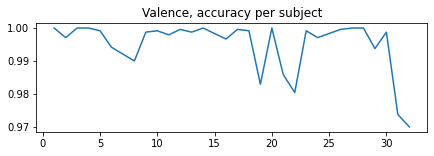

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (7, 2))
ax.plot(np.arange(1,33), acc_subs)
ax.set_title("Valence, accuracy per subject")

##Arousal

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score


#def get_mertics_per_subject():
k  = 5
type_emotion = 1

#acc_all = []
#f1_all = []
for sub in range(0,32):
    print(f"*******{sub}*********")

    args.batch_size = 100
    indexes = np.arange(NVIDEOS * 1 * LEN_RECORD_IN_SECONDS)
    n = len(indexes)
    #X = np.arange(40)
    y = []
    for nvideo in range(NVIDEOS):
        y.extend(60 * [labels_bin[sub][nvideo, type_emotion]])
    

    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    balanced_split = skf.split(indexes, y)
    acc_sub = []
    f1_sub = []
    for fold,  (inds_train, inds_test) in  enumerate(balanced_split):
        print(f"fold = {fold}")
        #print(inds_train, inds_test)
        #print(sum(labels_bin[sub][inds_train, type_emotion]))
        #print(sum(labels_bin[sub][inds_test, type_emotion]))
        args.batch_size = 100
        #transforms_random = RandomAugmentation([add_noise, reset_part_in_freq, reset_part_in_time, None], 0.2)
        #transforms = [RandomAugmentation([add_noise(), reset_part_in_freq(0.2), reset_part_in_time(0.2), None], 0.2), to_head_matrix(),ToTensor()]   
        transforms = [to_head_matrix(),ToTensor()] 
        #transforms = [RandomAugmentation([add_noise(), None], 0.5), to_head_matrix(),ToTensor()]   
        #transforms = [RandomAugmentation([reset_part_in_time(0.4), None], 0.1), to_head_matrix(),ToTensor()]   

        train_dataset = EmotionDataset(data[sub : sub + 1], labels_bin[sub : sub + 1], transforms, inds_train)
        train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                    pin_memory=True, shuffle=True, drop_last=True)

        val_dataset = EmotionDataset(data[sub: sub + 1], labels_bin[sub  : sub + 1], transforms,  inds_test)
        val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                              pin_memory=True, shuffle=False, drop_last=False)
        device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
        model.apply(initialize_weights)
        criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
        #optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
        optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
        train_loop(f'val_racnn_leak_{sub}_{fold}', 1, 50)
        description = f'batchnorm_Yes_batch_100_Adam_lr=3e4_{sub}_{fold}_subject2'
        model_state  = torch.load(os.path.join(args.output_dir, f"val_{description}.tgz"))
        #   #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
        model.load_state_dict(model_state['model_state_dict'])
        acc, f1 = calculate_predictions(model, val_dataloader, type_emotion)
        print(f"f1 = {f1} acc = {acc}")
        acc_sub.append(acc)
        f1_sub.append(f1)
        print(acc, f1)
    acc_all.append(acc_sub)     
    f1_all.append(f1_sub)     
    pd.DataFrame(f1_all).to_csv("f1_val_racnn_leak_result.csv")
    pd.DataFrame(acc_all).to_csv("acc_val_racnn_leak_result.csv")



    

*******1*********
fold = 0
f1 = 0.992514619883041 acc = 0.99375
0.99375 0.992514619883041
fold = 1
f1 = 0.9544294183421591 acc = 0.9625
0.9625 0.9544294183421591
fold = 2
f1 = 0.9975148976707343 acc = 0.9979166666666667
0.9979166666666667 0.9975148976707343
fold = 3
f1 = 0.9925446930122029 acc = 0.99375
0.99375 0.9925446930122029
fold = 4
f1 = 0.9799158978221301 acc = 0.9833333333333333
0.9833333333333333 0.9799158978221301
*******2*********
fold = 0
f1 = 1.0 acc = 1.0
1.0 1.0
fold = 1
f1 = 1.0 acc = 1.0
1.0 1.0
fold = 2
f1 = 1.0 acc = 1.0
1.0 1.0
fold = 3
f1 = 1.0 acc = 1.0
1.0 1.0
fold = 4
f1 = 0.9964093088667629 acc = 0.9979166666666667
0.9979166666666667 0.9964093088667629
*******3*********
fold = 0
f1 = 0.9972144685147895 acc = 0.9979166666666667
0.9979166666666667 0.9972144685147895
fold = 1
f1 = 1.0 acc = 1.0
1.0 1.0
fold = 2
f1 = 1.0 acc = 1.0
1.0 1.0
fold = 3
f1 = 0.9972144685147895 acc = 0.9979166666666667
0.9979166666666667 0.9972144685147895
fold = 4
f1 = 1.0 acc = 1.0
1.0 

In [ ]:
acc_data = pd.DataFrame(acc_all)

In [ ]:
acc_data_sub = acc_data.mean(axis = 1)

Text(0.5, 1.0, 'Valence, accuracy per subject')

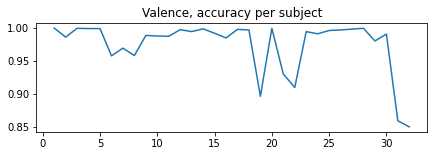

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (7, 2))
ax.plot(np.arange(1,33), acc_data_sub.values)
ax.set_title("Valence, accuracy per subject")

In [ ]:
print(f"Valence accuracy = {acc_data_sub.mean()} += {acc_data_sub.std()}" )

Valence accuracy = 0.9747526041666669 += 0.04068065313628254


In [ ]:
print(f1_data_1)

    f1_fold1  f1_fold2  f1_fold3  f1_fold4  f1_fold5
0   0.972092  0.982390  0.990040  0.987524  0.987524
1   1.000000  1.000000  1.000000  1.000000  1.000000
2   1.000000  1.000000  1.000000  1.000000  1.000000
3   0.997707  1.000000  0.997707  0.997707  0.997707
4   0.937988  0.980877  0.944914  0.985071  0.965899
5   0.997832  0.989121  0.960938  0.976065  0.978299
6   0.920145  0.947768  0.964328  0.958862  0.894387
7   0.991475  0.985090  0.963745  0.985090  0.989337
8   0.991667  0.987500  0.991666  0.947911  0.991667
9   0.987500  0.993750  0.995833  0.993750  0.985416
10  1.000000  0.997895  0.997895  0.997896  0.997895
11  0.987196  0.989337  0.989364  1.000000  0.993602
12  0.995421  1.000000  1.000000  0.997714  1.000000
13  0.975069  0.965896  0.985913  0.991596  0.977264
14  0.908425  0.983996  0.983952  0.993160  0.979191
15  1.000000  0.982534  0.997515  0.982673  0.997525
16  1.000000  0.993326  0.993341  1.000000  0.995556
17  0.884307  0.974788  0.947368  0.921891  0.

In [ ]:
import pandas as pd
acc_data_1 = pd.DataFrame(acc_all, columns = ['acc_fold1', 'acc_fold2', 'acc_fold3', 'acc_fold4', 'acc_fold5'])

In [ ]:
print(acc_data_1)

    acc_fold1  acc_fold2  acc_fold3  acc_fold4  acc_fold5
0    0.977083   0.985417   0.991667   0.989583   0.989583
1    1.000000   1.000000   1.000000   1.000000   1.000000
2    1.000000   1.000000   1.000000   1.000000   1.000000
3    0.997917   1.000000   0.997917   0.997917   0.997917
4    0.939583   0.981250   0.945833   0.985417   0.966667
5    0.997917   0.989583   0.962500   0.977083   0.979167
6    0.931250   0.954167   0.968750   0.964583   0.910417
7    0.991667   0.985417   0.964583   0.985417   0.989583
8    0.991667   0.987500   0.991667   0.947917   0.991667
9    0.987500   0.993750   0.995833   0.993750   0.985417
10   1.000000   0.997917   0.997917   0.997917   0.997917
11   0.987500   0.989583   0.989583   1.000000   0.993750
12   0.995833   1.000000   1.000000   0.997917   1.000000
13   0.981250   0.975000   0.989583   0.993750   0.983333
14   0.916667   0.985417   0.985417   0.993750   0.981250
15   1.000000   0.985417   0.997917   0.985417   0.997917
16   1.000000 

In [ ]:
f1_data_1.to_csv("f1_data_1.cav")
acc_data_1.to_csv("acc_data_1.csv")

In [ ]:
import pandas as pd

f1_data_0 = pd.read_csv("f1_data.csv")
acc_data_0 = pd.read_csv("acc_data.csv")
f1_data_1 = pd.read_csv("f1_data_1.csv")
acc_data_1 = pd.read_csv("acc_data_1.csv")

In [ ]:
result = pd.concat((acc_data_0, acc_data_1), axis = 0)

In [ ]:
print(result)

    index  Unnamed: 0  acc_fold1  acc_fold2  acc_fold3  acc_fold4  acc_fold5
0       0           0   1.000000   1.000000   1.000000   1.000000   1.000000
1       1           1   0.858333   0.889583   0.841667   0.908333   0.954167
2       2           2   0.997917   1.000000   0.995833   0.995833   0.995833
3       3           3   0.858333   0.870833   0.889583   0.825000   0.827083
4       0           0   0.977083   0.985417   0.991667   0.989583   0.989583
5       1           1   1.000000   1.000000   1.000000   1.000000   1.000000
6       2           2   1.000000   1.000000   1.000000   1.000000   1.000000
7       3           3   0.997917   1.000000   0.997917   0.997917   0.997917
8       4           4   0.939583   0.981250   0.945833   0.985417   0.966667
9       5           5   0.997917   0.989583   0.962500   0.977083   0.979167
10      6           6   0.931250   0.954167   0.968750   0.964583   0.910417
11      7           7   0.991667   0.985417   0.964583   0.985417   0.989583

In [ ]:
result = result.reset_index()

In [ ]:
result_mean = (result[['acc_fold1',  'acc_fold2' , 'acc_fold3' , 'acc_fold4' , 'acc_fold5']].mean(axis = 1))

In [ ]:
print(result_mean)

0     1.000000
1     0.890417
2     0.997083
3     0.854167
4     0.986667
5     1.000000
6     1.000000
7     0.998333
8     0.963750
9     0.981250
10    0.945833
11    0.983333
12    0.982083
13    0.991250
14    0.998333
15    0.992083
16    0.998750
17    0.984583
18    0.972500
19    0.993333
20    0.996667
21    0.926667
22    0.999167
23    0.919167
24    0.915833
25    0.988333
26    0.994583
27    0.996667
28    0.997083
29    0.998333
30    1.000000
31    0.958333
dtype: float64


In [ ]:
print(result_mean.mean(), result_mean.std())

0.9751432291666664 0.036369705543911224


Text(0.5, 1.0, 'Arousal, accuracy per subject')

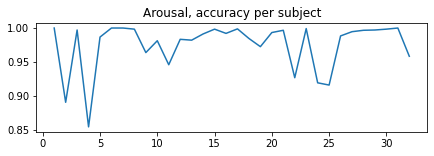

In [ ]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 1, figsize = (7, 2))
ax.plot(np.arange(1,33), result_mean.values)
ax.set_title("Arousal, accuracy per subject")

In [ ]:
c = list(set(inds_train) & set(inds_test))
print(c)

[]


#Результаты на датасете без лика

In [ ]:
import glob
import pickle
from collections import Counter
import scipy
from  scipy import signal
from scipy.fft import fft, fftfreq

class EmotionDataset_balanced(Dataset):
    def __init__ (self, indexes, data, labels_bin):  #indexes - индексы видео которые вошли в датасет, data - данные labels - метки бинарные
       self.data = []
       self.labels = []
       self.cnt = [Counter(), Counter(), Counter(),Counter()]
       self.indexes = indexes
       self.len_files = []
       for sub in range(len(data)): #sub   - человек
            self.data.append(data[sub][indexes[sub], :, 3 * NTIMES_IN_SEC :  LEN_RECORD_IN_SECONDS * NTIMES_IN_SEC + 3 * NTIMES_IN_SEC])
            self.len_files.append(len(indexes[sub]) *  LEN_RECORD_IN_SECONDS - 1) #столько записей будет храниться для каждого человека - количство видео для человека на 60 сек
            self.len_record = LEN_RECORD_IN_SECONDS
            labels_bin_sub = (labels_bin[sub])
            self.labels.append(labels_bin_sub[indexes[sub]])          
            # счетчик числа 1 и 0 в датасете
            for type_emotion in range(4):
              self.cnt[type_emotion].update(list(self.labels[-1][:, type_emotion]))    

            
       self.len_cumsum = np.cumsum(self.len_files)     


    # общее число сеймплов по 1 сек в датасете. их будет 32 * количество видео в датасете * 60 
    def __len__(self):
        result =  sum(self.len_files) - 10
        return result


    # по номеру сеймпла вытягиваем номер человека номер видео и номер секунды
    def get_index_record(self, item):
      for sub in range(len(self.len_cumsum)):
         #print(item, self.len_cumsum[i_file])
         if (item > self.len_cumsum[sub]):
            continue
         else:
            break
      if sub == 0:
         index_in_file = item
      else:
         index_in_file = item  - self.len_cumsum[sub - 1]
      nvideo = index_in_file//(self.len_record)# * LEN_RECORD_IN_SECONDS *  NTIMES_IN_SEC)
      nsec = (index_in_file - nvideo * self.len_record) # *   NTIMES_IN_SEC)

      return sub, nvideo, nsec

   
    def __getitem__(self, item):
      sample = {}
      #print(item)
      sub, nvideo, nsec = self.get_index_record(item)
      #print(i_file, index_in_file, nvideo, nsec )
      sample['data'] = np.zeros((HCANALS, WCANALS, NTIMES_IN_SAMPLE))
      sample_from_one_canals = []
      for i_canal in range(NCANALS):
        sample_from_one_canal1 = self.data[sub][nvideo, i_canal, nsec * 128 : nsec * 128 + 128]
        power = fft(sample_from_one_canal1)
        #sample_from_one_canals.append(sample_from_one_canal)
        sample_from_one_canals.append([0] * 128)
        #print(sample_from_one_canal.shape)
      sample_from_one_canals = np.asarray(sample_from_one_canals).copy()
      # здесь делаем нормализацию фактически по поверхности головы (по одному времени t для всех каналов)
      #sample_from_one_canals = scipy.stats.zscore(sample_from_one_canals, axis = 0)
      for i_canal in range(NCANALS):
          sample['data'][electrode_matrix[list_electrodes[i_canal]][0],  electrode_matrix[list_electrodes[i_canal]][1]] = sample_from_one_canals[i_canal]
      sample['data'] = torch.FloatTensor(sample['data'])
      sample['labels']  = torch.LongTensor(self.labels[sub][nvideo])
      sample['position'] = torch.LongTensor((sub, nvideo, nsec))
      
      return sample

Valence Correct Per sub model

In [45]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd


#def get_mertics_per_subject():
k  = 5
type_emotion = 0
acc_all = []
f1_all = []

for sub in range(0, 32):
    print(f"*******{sub}*********")

    args.batch_size = 100
    X = np.arange(40)
    y = np.array(labels_bin[sub][:, type_emotion])
    

    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    balanced_split = skf.split(X, y)
    acc_sub = []
    f1_sub = []
   
    for fold,  (ind_train, ind_test) in  enumerate(balanced_split):
        inds_train = []
        inds_test = []
        inds_train.append(ind_train)
        inds_test.append(ind_test)
        print(f"fold = {fold}")
        #print(inds_train, inds_test)
        #print(sum(labels_bin[sub][inds_train, type_emotion]))
        #print(sum(labels_bin[sub][inds_test, type_emotion]))
        args.batch_size = 100
        #transforms_random = RandomAugmentation([add_noise, reset_part_in_freq, reset_part_in_time, None], 0.2)
        #transforms = [RandomAugmentation([add_noise(), reset_part_in_freq(0.2), reset_part_in_time(0.2), None], 0.2), to_head_matrix(),ToTensor()]   
        transforms = [to_head_matrix(),ToTensor()] 
        #transforms = [RandomAugmentation([add_noise(), None], 0.5), to_head_matrix(),ToTensor()]   
        #transforms = [RandomAugmentation([reset_part_in_time(0.4), None], 0.1), to_head_matrix(),ToTensor()]   

        train_dataset = EmotionDataset_balanced(inds_train[0:1], data[sub:sub+1], labels_bin[sub:sub+1])
        #class_weights_all = [1/train_dataset.cnt[0][i] for i in range(2)]
        #weights_samples =  [0] * train_dataset.__len__()

        #A = np.zeros((32, 40, 60))

        # for i in range(train_dataset.__len__()):
        #     sub, nvideo, nsec = train_dataset.get_index_record(i)
        #     #A[sub, nvideo, nsec] = 1
        #     #print(train_dataset.labels[i_file][nvideo])
        #     weights_samples[i] = class_weights_all[int(train_dataset.labels[sub][nvideo, type_emotion])]

        # weighted_sampler = WeightedRandomSampler(
        #     weights=weights_samples,
        #     num_samples=len(weights_samples),
        #     replacement=True
        # )
        # train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
        #                               pin_memory=True, shuffle=False, drop_last=True, sampler=weighted_sampler)

        train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                        pin_memory=True, shuffle=True, drop_last=True)

        val_dataset = EmotionDataset_balanced(inds_test[0:1], data[sub:sub+1], labels_bin[sub:sub+1])
        val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                                      pin_memory=True, shuffle=False, drop_last=False)
        device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
        model.apply(initialize_weights)
        criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
        #optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
        optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
        train_loop(f'batchnorm_Yes_batch_100_Adam_lr=3e4_{sub}_{fold}_subject_proper', 0, 20)
        description = f'batchnorm_Yes_batch_100_Adam_lr=3e4_{sub}_{fold}_subject_proper'
        model_state  = torch.load(os.path.join(args.output_dir, f"val_{description}.tgz"))
        #   #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
        model.load_state_dict(model_state['model_state_dict'])
        acc, f1 = calculate_predictions(model, val_dataloader, type_emotion, True)
        print(f"f1 = {f1} acc = {acc}")
        acc_sub.append(acc)
        f1_sub.append(f1)
        print(acc, f1)
    acc_all.append(acc_sub)     
    f1_all.append(f1_sub)     
    pd.DataFrame(f1_all).to_csv("f1_data_val_racnn_noleak.csv")
    pd.DataFrame(acc_all).to_csv("acc_data_val_racnn_noleak.csv")

*******0*********
fold = 0
0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[240   0]
 [229   0]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       240
           1       0.00      0.00      0.00       229

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
*******1*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3837953091684435
[[180   0]
 [289   0]]
              precision    recall  f1-score   support

           0       0.38      1.00      0.55       180
           1       0.00      0.00      0.00       289

    accuracy                           0.38       469
   macro avg       0.19      0.50      0.28       469
weighted avg       0.15      0.38      0.21       469

f1 = 0.27734976887519264 acc = 0.3837953091684435
0.3837953091684435 0.27734976887519264
*******2*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8720682302771855
[[  0  60]
 [  0 409]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.87      1.00      0.93       409

    accuracy                           0.87       469
   macro avg       0.44      0.50      0.47       469
weighted avg       0.76      0.87      0.81       469

f1 = 0.4658314350797267 acc = 0.8720682302771855
0.8720682302771855 0.4658314350797267
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8720682302771855
[[  0  60]
 [  0 409]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.87      1.00      0.93       409

    accuracy                           0.87       469
   macro avg       0.44      0.50      0.47       469
weighted avg       0.76      0.87      0.81       469

f1 = 0.4658314350797267 acc = 0.8720682302771855
0.8720682302771855 0.4658314350797267
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8955223880597015
[[  0  49]
 [  0 420]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.90      1.00      0.94       420

    accuracy                           0.90       469
   macro avg       0.45      0.50      0.47       469
weighted avg       0.80      0.90      0.85       469

f1 = 0.4724409448818898 acc = 0.8955223880597015
0.8955223880597015 0.4724409448818898
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
*******3*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.255863539445629
[[120   0]
 [349   0]]
              precision    recall  f1-score   support

           0       0.26      1.00      0.41       120
           1       0.00      0.00      0.00       349

    accuracy                           0.26       469
   macro avg       0.13      0.50      0.20       469
weighted avg       0.07      0.26      0.10       469

f1 = 0.2037351443123939 acc = 0.255863539445629
0.255863539445629 0.2037351443123939
*******4*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
*******5*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
*******6*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
*******7*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
*******8*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3603411513859275
[[169   0]
 [300   0]]
              precision    recall  f1-score   support

           0       0.36      1.00      0.53       169
           1       0.00      0.00      0.00       300

    accuracy                           0.36       469
   macro avg       0.18      0.50      0.26       469
weighted avg       0.13      0.36      0.19       469

f1 = 0.26489028213166144 acc = 0.3603411513859275
0.3603411513859275 0.26489028213166144
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.488272921108742
[[229   0]
 [240   0]]
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       229
           1       0.00      0.00      0.00       240

    accuracy                           0.49       469
   macro avg       0.24      0.50      0.33       469
weighted avg       0.24      0.49      0.32       469

f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.488272921108742
[[  0 240]
 [  0 229]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       240
           1       0.49      1.00      0.66       229

    accuracy                           0.49       469
   macro avg       0.24      0.50      0.33       469
weighted avg       0.24      0.49      0.32       469

f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
*******9*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
*******10*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[240   0]
 [229   0]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       240
           1       0.00      0.00      0.00       229

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[240   0]
 [229   0]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       240
           1       0.00      0.00      0.00       229

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
*******11*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
*******12*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[300   0]
 [169   0]]
              precision    recall  f1-score   support

           0       0.64      1.00      0.78       300
           1       0.00      0.00      0.00       169

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[289   0]
 [180   0]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       289
           1       0.00      0.00      0.00       180

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[289   0]
 [180   0]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       289
           1       0.00      0.00      0.00       180

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[240   0]
 [229   0]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       240
           1       0.00      0.00      0.00       229

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.488272921108742
[[229   0]
 [240   0]]
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       229
           1       0.00      0.00      0.00       240

    accuracy                           0.49       469
   macro avg       0.24      0.50      0.33       469
weighted avg       0.24      0.49      0.32       469

f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
*******13*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
*******14*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
*******15*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
*******16*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
*******17*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
*******18*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.488272921108742
[[229   0]
 [240   0]]
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       229
           1       0.00      0.00      0.00       240

    accuracy                           0.49       469
   macro avg       0.24      0.50      0.33       469
weighted avg       0.24      0.49      0.32       469

f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
*******19*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8720682302771855
[[  0  60]
 [  0 409]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.87      1.00      0.93       409

    accuracy                           0.87       469
   macro avg       0.44      0.50      0.47       469
weighted avg       0.76      0.87      0.81       469

f1 = 0.4658314350797267 acc = 0.8720682302771855
0.8720682302771855 0.4658314350797267
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8720682302771855
[[  0  60]
 [  0 409]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.87      1.00      0.93       409

    accuracy                           0.87       469
   macro avg       0.44      0.50      0.47       469
weighted avg       0.76      0.87      0.81       469

f1 = 0.4658314350797267 acc = 0.8720682302771855
0.8720682302771855 0.4658314350797267
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
*******20*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.488272921108742
[[229   0]
 [240   0]]
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       229
           1       0.00      0.00      0.00       240

    accuracy                           0.49       469
   macro avg       0.24      0.50      0.33       469
weighted avg       0.24      0.49      0.32       469

f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[240   0]
 [229   0]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       240
           1       0.00      0.00      0.00       229

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[289   0]
 [180   0]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       289
           1       0.00      0.00      0.00       180

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
*******21*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
*******22*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
*******23*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8720682302771855
[[  0  60]
 [  0 409]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.87      1.00      0.93       409

    accuracy                           0.87       469
   macro avg       0.44      0.50      0.47       469
weighted avg       0.76      0.87      0.81       469

f1 = 0.4658314350797267 acc = 0.8720682302771855
0.8720682302771855 0.4658314350797267
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8955223880597015
[[  0  49]
 [  0 420]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.90      1.00      0.94       420

    accuracy                           0.90       469
   macro avg       0.45      0.50      0.47       469
weighted avg       0.80      0.90      0.85       469

f1 = 0.4724409448818898 acc = 0.8955223880597015
0.8955223880597015 0.4724409448818898
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.8955223880597015
[[  0  49]
 [  0 420]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.90      1.00      0.94       420

    accuracy                           0.90       469
   macro avg       0.45      0.50      0.47       469
weighted avg       0.80      0.90      0.85       469

f1 = 0.4724409448818898 acc = 0.8955223880597015
0.8955223880597015 0.4724409448818898
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
*******24*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
*******25*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[240   0]
 [229   0]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       240
           1       0.00      0.00      0.00       229

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
*******26*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
*******27*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
*******28*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6396588486140725
[[  0 169]
 [  0 300]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       169
           1       0.64      1.00      0.78       300

    accuracy                           0.64       469
   macro avg       0.32      0.50      0.39       469
weighted avg       0.41      0.64      0.50       469

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[240   0]
 [229   0]]
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       240
           1       0.00      0.00      0.00       229

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
*******29*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
*******30*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.488272921108742
[[229   0]
 [240   0]]
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       229
           1       0.00      0.00      0.00       240

    accuracy                           0.49       469
   macro avg       0.24      0.50      0.33       469
weighted avg       0.24      0.49      0.32       469

f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.511727078891258
[[  0 229]
 [  0 240]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       229
           1       0.51      1.00      0.68       240

    accuracy                           0.51       469
   macro avg       0.26      0.50      0.34       469
weighted avg       0.26      0.51      0.35       469

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[289   0]
 [180   0]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       289
           1       0.00      0.00      0.00       180

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[289   0]
 [180   0]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       289
           1       0.00      0.00      0.00       180

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[289   0]
 [180   0]]
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       289
           1       0.00      0.00      0.00       180

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
*******31*********
fold = 0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.767590618336887
[[  0 109]
 [  0 360]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.77      1.00      0.87       360

    accuracy                           0.77       469
   macro avg       0.38      0.50      0.43       469
weighted avg       0.59      0.77      0.67       469

f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.744136460554371
[[  0 120]
 [  0 349]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.74      1.00      0.85       349

    accuracy                           0.74       469
   macro avg       0.37      0.50      0.43       469
weighted avg       0.55      0.74      0.63       469

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.6162046908315565
[[  0 180]
 [  0 289]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.62      1.00      0.76       289

    accuracy                           0.62       469
   macro avg       0.31      0.50      0.38       469
weighted avg       0.38      0.62      0.47       469

f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd

f1_data_val_noleak = pd.read_csv("f1_data_val_noleak.csv")
acc_data_val_noleak = pd.read_csv("acc_data_val_noleak.csv")

In [ ]:
print(f1_data_val_noleak)

    Unnamed: 0         0         1         2         3         4
0            0  0.338505  0.338505  0.328080  0.338505  0.328080
1            1  0.188581  0.426650  0.434258  0.264890  0.381266
2            2  0.465831  0.465831  0.465831  0.434258  0.426650
3            3  0.426650  0.434258  0.426650  0.426650  0.426650
4            4  0.426650  0.390117  0.381266  0.390117  0.390117
5            5  0.381266  0.264890  0.381266  0.338505  0.338505
6            6  0.390117  0.390117  0.390117  0.390117  0.338505
7            7  0.434258  0.434258  0.390117  0.381266  0.381266
8            8  0.390117  0.390117  0.390117  0.328080  0.338505
9            9  0.338505  0.338505  0.338505  0.338505  0.338505
10          10  0.338505  0.338505  0.328080  0.338505  0.338505
11          11  0.264890  0.390117  0.338505  0.328080  0.338505
12          12  0.381266  0.381266  0.381266  0.338505  0.338505
13          13  0.381266  0.390117  0.381266  0.390117  0.434258
14          14  0.434258 

In [ ]:
f1 = f1_data_val_noleak[['0', '1', '2', '3' ,'4']].mean(axis = 1)
acc = acc_data_val_noleak[['0', '1', '2', '3' ,'4']].mean(axis = 1)
print(f1.mean())
print(acc.mean())
print(f1.std())
print(acc.std())

0.3856141715059626
0.6367651538227233
0.038355339271290485
0.10208998087688206


Arrousal Correct Per sub model

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd

#def get_mertics_per_subject():
k  = 5
type_emotion = 1
#acc_all = []
#f1_all = []

for sub in range(1, 32):
    print(f"*******{sub}*********")

    args.batch_size = 100
    X = np.arange(40)
    y = np.array(labels_bin[sub][:, type_emotion])
    

    skf = StratifiedKFold(n_splits=k, random_state=None, shuffle=True)
    balanced_split = skf.split(X, y)
    acc_sub = []
    f1_sub = []
   
    for fold,  (ind_train, ind_test) in  enumerate(balanced_split):
        inds_train = []
        inds_test = []
        inds_train.append(ind_train)
        inds_test.append(ind_test)
        print(f"fold = {fold}")
        #print(inds_train, inds_test)
        #print(sum(labels_bin[sub][inds_train, type_emotion]))
        #print(sum(labels_bin[sub][inds_test, type_emotion]))
        args.batch_size = 100
        #transforms_random = RandomAugmentation([add_noise, reset_part_in_freq, reset_part_in_time, None], 0.2)
        #transforms = [RandomAugmentation([add_noise(), reset_part_in_freq(0.2), reset_part_in_time(0.2), None], 0.2), to_head_matrix(),ToTensor()]   
        transforms = [to_head_matrix(),ToTensor()] 
        #transforms = [RandomAugmentation([add_noise(), None], 0.5), to_head_matrix(),ToTensor()]   
        #transforms = [RandomAugmentation([reset_part_in_time(0.4), None], 0.1), to_head_matrix(),ToTensor()]   

        train_dataset = EmotionDataset_balanced(inds_train[0:1], data[sub:sub+1], labels_bin[sub:sub+1])
        #class_weights_all = [1/train_dataset.cnt[0][i] for i in range(2)]
        #weights_samples =  [0] * train_dataset.__len__()

        #A = np.zeros((32, 40, 60))

        # for i in range(train_dataset.__len__()):
        #     sub, nvideo, nsec = train_dataset.get_index_record(i)
        #     #A[sub, nvideo, nsec] = 1
        #     #print(train_dataset.labels[i_file][nvideo])
        #     weights_samples[i] = class_weights_all[int(train_dataset.labels[sub][nvideo, type_emotion])]

        # weighted_sampler = WeightedRandomSampler(
        #     weights=weights_samples,
        #     num_samples=len(weights_samples),
        #     replacement=True
        # )
        # train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
        #                               pin_memory=True, shuffle=False, drop_last=True, sampler=weighted_sampler)

        train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=1,
                                        pin_memory=True, shuffle=True, drop_last=True)

        val_dataset = EmotionDataset_balanced(inds_test[0:1], data[sub:sub+1], labels_bin[sub:sub+1])
        val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=1,
                                      pin_memory=True, shuffle=False, drop_last=False)
        device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = get_model(batch_norm = True, reg_extractor = True, ass_extractor = True)
        model.apply(initialize_weights)
        criterion = nn.CrossEntropyLoss(reduction = 'mean')#torch.nn.MSELoss()
        #optimizer = optim.SGD(model.parameters(), lr=3e-5, momentum = 0.9)#, weight_decay=args.weight_decay)
        optimizer = optim.Adam(model.parameters(), lr=3e-4)#, momentum = 0.9)#, weight_decay=args.weight_decay)
        train_loop(f'batchnorm_Yes_batch_100_Adam_lr=3e4_{sub}_{fold}_subject_proper', 0, 20)
        description = f'batchnorm_Yes_batch_100_Adam_lr=3e4_{sub}_{fold}_subject_proper'
        model_state  = torch.load(os.path.join(args.output_dir, f"val_{description}.tgz"))
        #   #model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device)
        model.load_state_dict(model_state['model_state_dict'])
        acc, f1 = calculate_predictions(model, val_dataloader, type_emotion)
        print(f"f1 = {f1} acc = {acc}")
        acc_sub.append(acc)
        f1_sub.append(f1)
        print(acc, f1)
    acc_all.append(acc_sub)     
    f1_all.append(f1_sub)     
    pd.DataFrame(f1_all).to_csv("f1_data_val_noleak.csv")
    pd.DataFrame(acc_all).to_csv("acc_data_val_noleak.csv")

*******1*********
fold = 0
f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 1
f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 2
f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 3
f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 4
f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
*******2*********
fold = 0
f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
fold = 1
f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 2
f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
fold = 3
f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
fold = 4
f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_cl

f1 = 0.26489028213166144 acc = 0.3603411513859275
0.3603411513859275 0.26489028213166144
fold = 1
f1 = 0.26489028213166144 acc = 0.3603411513859275
0.3603411513859275 0.26489028213166144
fold = 2
f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
fold = 3
f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 4
f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
*******8*********
fold = 0
f1 = 0.4658314350797267 acc = 0.8720682302771855
0.8720682302771855 0.4658314350797267
fold = 1
f1 = 0.4658314350797267 acc = 0.8720682302771855
0.8720682302771855 0.4658314350797267
fold = 2
f1 = 0.11342155009451795 acc = 0.1279317697228145
0.1279317697228145 0.11342155009451795
fold = 3
f1 = 0.4658314350797267 acc = 0.8720682302771855
0.8720682302771855 0.4658314350797267
fold = 4
f1 = 0.4658314350797267 acc = 0.8720682302771855
0.8720682302771855 0.4658314350797267
*******9*********
fold = 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_cl

f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 2
f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 3
f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 4
f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
*******15*********
fold = 0
f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 1
f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 2
f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 3
f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 4
f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
*******16*********
fold = 0
f1 = 0.4724409448818898 acc = 0.8955223880597015
0.8955223880597015 0.4724409448818898
fold = 1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_cl

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
*******24*********
fold = 0
f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 1
f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
fold = 2
f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
fold = 3
f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
fold = 4
f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
*******25*********
fold = 0
f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 1
f1 = 0.2037351443123939 acc = 0.255863539445629
0.255863539445629 0.2037351443123939
fold = 2
f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 3
f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
fold = 4
f1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_cl

f1 = 0.33850493653032443 acc = 0.511727078891258
0.511727078891258 0.33850493653032443
fold = 4
f1 = 0.32808022922636104 acc = 0.488272921108742
0.488272921108742 0.32808022922636104
*******28*********
fold = 0
f1 = 0.4342581423401689 acc = 0.767590618336887
0.767590618336887 0.4342581423401689
fold = 1
f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 2
f1 = 0.42665036674816625 acc = 0.744136460554371
0.744136460554371 0.42665036674816625
fold = 3
f1 = 0.2037351443123939 acc = 0.255863539445629
0.255863539445629 0.2037351443123939
fold = 4
f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715
*******29*********
fold = 0
f1 = 0.2037351443123939 acc = 0.255863539445629
0.255863539445629 0.2037351443123939
fold = 1
f1 = 0.18858131487889274 acc = 0.232409381663113
0.232409381663113 0.18858131487889274
fold = 2
f1 = 0.18858131487889274 acc = 0.232409381663113
0.232409381663113 0.18858131487889274
fold = 3
f1 = 0.1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_cl

f1 = 0.39011703511053314 acc = 0.6396588486140725
0.6396588486140725 0.39011703511053314
fold = 4
f1 = 0.3812664907651715 acc = 0.6162046908315565
0.6162046908315565 0.3812664907651715


In [ ]:
import pandas as pd

f1_data_arousal_noleak = pd.read_csv("f1_data_racnn_arousal_noleak.csv")
acc_data_arousal_noleak = pd.read_csv("acc_data_racnn_arousal_noleak.csv")

In [ ]:
print(f1_data_arousal_noleak)

    Unnamed: 0         0         1         2         3         4
0            0  0.381266  0.381266  0.381266  0.381266  0.390117
1            1  0.381266  0.381266  0.390117  0.381266  0.390117
2            2  0.328080  0.338505  0.328080  0.328080  0.381266
3            3  0.381266  0.381266  0.381266  0.381266  0.381266
4            4  0.472441  0.426650  0.203735  0.434258  0.203735
5            5  0.277350  0.426650  0.426650  0.426650  0.426650
6            6  0.381266  0.381266  0.381266  0.328080  0.328080
7            7  0.264890  0.264890  0.328080  0.338505  0.328080
8            8  0.465831  0.465831  0.113422  0.465831  0.465831
9            9  0.113422  0.465831  0.465831  0.465831  0.113422
10          10  0.426650  0.203735  0.277350  0.381266  0.381266
11          11  0.381266  0.381266  0.338505  0.328080  0.328080
12          12  0.338505  0.338505  0.338505  0.328080  0.338505
13          13  0.426650  0.381266  0.381266  0.381266  0.381266
14          14  0.434258 

In [ ]:

print(acc_data_arousal_noleak)

    Unnamed: 0         0         1         2         3         4
0            0  0.616205  0.616205  0.616205  0.616205  0.639659
1            1  0.616205  0.616205  0.639659  0.616205  0.639659
2            2  0.488273  0.511727  0.488273  0.488273  0.616205
3            3  0.616205  0.616205  0.616205  0.616205  0.616205
4            4  0.895522  0.744136  0.255864  0.767591  0.255864
5            5  0.383795  0.744136  0.744136  0.744136  0.744136
6            6  0.616205  0.616205  0.616205  0.488273  0.488273
7            7  0.360341  0.360341  0.488273  0.511727  0.488273
8            8  0.872068  0.872068  0.127932  0.872068  0.872068
9            9  0.127932  0.872068  0.872068  0.872068  0.127932
10          10  0.744136  0.255864  0.383795  0.616205  0.616205
11          11  0.616205  0.616205  0.511727  0.488273  0.488273
12          12  0.511727  0.511727  0.511727  0.488273  0.511727
13          13  0.744136  0.616205  0.616205  0.616205  0.616205
14          14  0.767591 

In [ ]:
f1 = f1_data_arousal_noleak[['0', '1', '2', '3' ,'4']].mean(axis = 1)
acc = acc_data_arousal_noleak[['0', '1', '2', '3' ,'4']].mean(axis = 1)
print(f1.mean())
print(acc.mean())
print(f1.std())
print(acc.std())

0.36006763069814185
0.5877798507462686
0.056209439253919545
0.12630776122037268
